<p style="text-align: center"><a href='https://twinsolar.eu/'><img src="https://twinsolar.eu/wp-content/uploads/2023/03/logo_twinsolar_seul.png" width="200"><img src="https://twinsolar.eu/wp-content/uploads/2023/03/EN_FundedbytheEU_RGB_POS.png" width="200"></p></p></a>
<p style="text-align: center"><a href='https://twinsolar.eu/'>https://twinsolar.eu/</a></p>

# Workshop: Modelling individual components and a whole energy system, which integrates a large share of variable renewables

<h2>Part 1: PV system modelling</h2>

This Jupyter Notebook proposes a model for the PV plant installed on the roof of the ENERPOS building based on the <a href = "https://pvlib-python.readthedocs.io">pvlib</a> library.

<h3>PV system of the ENERPOS building</h3>

<img width="400" src="https://github.com/Laboratoire-Piment/TwInSolar_PV_system_modelling/blob/9011d6bf4749a154f22b3fd0aa80439e8b3ed8ca/images/ENERPOS_Balleydier.png?raw=true">

The PV system is integrated on the over-roofs of the building and it has been commissionned in 2008. 144 modules TENESOL TE2000 with a rated power of 210 Wp cover 2 roofs with opposite orientations. Details of the system are summarized below :

<b>Roof 1: over-roof well ventilated, slope 9°, 14° North-East, 18.9 kWp</b>
* Inverter 1 DELTA RPI M10A / MPPT 1: 36 modules, 7.56 kWp
* Inverter 1 DELTA RPI M10A / MPPT 2: 18 modules, 3.78 kWp
* Inverter 2 DELTA RPI M10A / MPPT 1: 18 modules, 3.78 kWp
* Inverter 2 DELTA RPI M10A / MPPT 2: 18 modules, 3.78 kWp

<b>Roof 2: over-roof well ventilated, slope 9°, 194° South-West, 30.24 kWp</b>
* Inverter 3 DELTA RPI M15A / MPPT 1: 36 modules, 7.56 kWp
* Inverter 3 DELTA RPI M15A / MPPT 2: 36 modules, 7.56 kWp
* Inverter 4 DELTA RPI M15A / MPPT 1: 36 modules, 7.56 kWp
* Inverter 4 DELTA RPI M15A / MPPT 2: 36 modules, 7.56 kWp

In [2]:
# Init environement
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pvlib
from pvlib.modelchain import ModelChain
from pvlib import pvsystem

/Users/mdavid/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


<h3>Define the location of the PV plant and load weather file</h3>

In [3]:
# Coordinates of the PV plant
latitude = -21.333
longitude = 55.483
altitude = 75.0

# Define the location object
location = pvlib.location.Location(latitude, longitude, altitude=altitude)

# Import weather data from file
df_weather = pd.read_csv('Meteo_Terre_Sainte_01-15-10-2022.txt')

# Subset variables needed
df_weather = df_weather[['datetime', 'GHI', 'DHI', 'BNI','DBT', 'Ws10']]
df_weather.rename(columns={'GHI':'ghi', 'DHI':'dhi', 'BNI':'dni','DBT':'temp_air', 'Ws10':'wind_speed'},inplace=True)
# Time as index
df_weather['datetime'] = pd.to_datetime(df_weather.datetime)
df_weather.set_index('datetime', inplace=True)

df_weather.head()

,ghi,dhi,dni,temp_air,wind_speed
datetime,,,,,
2022-10-01 00:00:00+04:00,0.0,0.0,0.0,19.334,1.8955
2022-10-01 00:10:00+04:00,0.0,0.0,0.0,19.077,0.7622
2022-10-01 00:20:00+04:00,0.0,0.0,0.0,19.079,0.6355
2022-10-01 00:30:00+04:00,0.0,0.0,0.0,19.141,1.2122
2022-10-01 00:40:00+04:00,0.0,0.0,0.0,18.595,0.5601


<h3>Define PV module</h3>

The polycristaline modules TENESOL TE2000 of the ENERPOS system are not present in CEC file provided with the pvlib library. The technical datasheet is available <a href = "TE220_TENESOL.pdf">here</a> (only in French). The table below provide the main characteristics of the modules. The parameters provided in the manufacturer's datasheet are stored in the file Custom-cec-modules.csv. The Notebook <a href='PV_modules.ipynb'>PV_modules.ipynb</a>) gives insights on the PV IV curve generation with the single diode model.

| Characteristics                   | STC$^*$   | NOCT$^{**}$  |   | Characteristics     |              |
|-----------------------------------|-----------|--------------|---|---------------------|--------------|
| Typical peak power                |     210 W |      147.8 W |   | Power temp. coef.   |   -0.46 %/°C |
| Voltage at peak power ($V_{mp}$)  |    26.7 V |       24.4 V |   | Voltage temp. coef. | -116.1 mV/°C |
| Intensity at peak power ($I_{mp}$)|     7.5 A |        6.1 A |   | Current temp. coef. |   +4.4 mA/°C |
| Open circuit voltage ($V_{sc}$)   |    32.7 V |       30.5 V |   | Module length       |       1.51 m |
| Short circuit current ($I_{sc}$)  |     7.8 A |        6.5 V |   | Module width        |      0.995 m |
| Cell temperature                  |      25°C |         45°C |   | Number of cells     |           54 |

<font size=1>$^*$ Standard Test Conditions (STC): 1000 W/m$^2$, 1.5 AM, and cell temperature 25°C</font>

<font size=1>$^{**}$ NOCT test: 1000 W/m$^2$, 1.5 AM, ambiant temperature 20°C, and wind speed 1 m/s</font>

In [4]:
# Create module model from the datasheet

# Import module specs from custom CEC file
module_database = pvsystem.retrieve_sam(path = 'Custom-cec-modules.csv')
module_TE2000 = module_database.TENESOL_TE2000_210W

# Estimate the parameters for the CEC single diode model
""" WARNING - This function relies on NREL's SAM tool. So PySAM, its Python API, needs to be installed 
in the same computer. Otherwise, you can expect the following error: 'ImportError if NREL-PySAM is not installed.'
"""
module_TE2000.I_L_ref, module_TE2000.I_o_ref, module_TE2000.R_s, module_TE2000.R_sh_ref, module_TE2000.a_ref, module_TE2000.Adjust = pvlib.ivtools.sdm.fit_cec_sam(
    celltype = module_TE2000.Technology,
    v_mp = module_TE2000.V_mp_ref, 
    i_mp = module_TE2000.I_mp_ref,
    v_oc = module_TE2000.V_oc_ref, 
    i_sc = module_TE2000.I_sc_ref, 
    alpha_sc = module_TE2000.alpha_sc,
    beta_voc = module_TE2000.beta_oc, 
    gamma_pmp = module_TE2000.gamma_r,
    cells_in_series = module_TE2000.N_s, 
    temp_ref = 25)

# Let's have a look to the module specs
print(module_TE2000)

Technology       multiSi
Bifacial               0
STC                  210
PTC                147.8
A_c             1.325126
Length              1.51
Width              0.995
N_s                   54
I_sc_ref             8.0
V_oc_ref            32.9
I_mp_ref             7.5
V_mp_ref            26.7
alpha_sc          0.0044
beta_oc          -0.1161
T_NOCT              45.0
a_ref           1.397766
I_L_ref          8.00658
I_o_ref              0.0
R_s              0.28049
R_sh_ref      341.003245
Adjust          6.650831
gamma_r            -0.46
BIPV                   N
Version           Custom
Date          01/03/2019
Name: TENESOL_TE2000_210W, dtype: object


<h3>Define inverters</h3>

Two inverter models are installed (see technical data above). Their parameters have been generated with a specific pvlib function (see <a href='Inverter_parameters.ipynb'>Inverter_parameters.ipynb</a>) and they are stored in the file Custom-cec-inverters.csv.

1. DELTA Electronics RPI M10A

<p  style='text-align: center'><img width="300" src = "https://solarsolutions.delta-emea.com/img/SOLAR%20Solutions%20-%20EMEA/m6_8_10a_image_two_hd_rdax_1140x641.jpg"><img width="300" src='https://github.com/Laboratoire-Piment/TwInSolar_PV_system_modelling/blob/main/images/Inverter_DETLA_RPI_M10A.jpg?raw=true'></p>

| AC output |       |  | DC input |       |
|-----------|-------|--|----------|-------|
| Rated AC power | 10kW |  | Max DC power | 11kW |
| Max AC power | 10.5kW |  | Nominal DC voltage | 600V |
| AC voltage | 3 phase 230/400V |  | MPP tracker | 2 |
| Maximum efficiency | 98.3% |  | MMPT voltage range | 415V - 800V |

<p style='text-align: center'>Table: Inverter DELTA RPI M10A Technical data (<a href='https://solarsolutions.delta-emea.com/en/M10A-209.htm'>complete datasheet here</a>)</p>

2. DELTA Electronics RPI M15A

<p  style='text-align: center'><img width="300" src = 'https://github.com/Laboratoire-Piment/TwInSolar_PV_system_modelling/blob/main/images/Inverter_DELTA_RPI_M15A.jpg?raw=true'></p>

| AC output |       |  | DC input |       |
|-----------|-------|--|----------|-------|
| Rated AC power | 15kW |  | Max DC power | 19kW |
| Max AC power | 16.5kW |  | Nominal DC voltage | 600V |
| AC voltage | 3 phase 230/400V |  | MPP tracker | 2 |
| Maximum efficiency | 98.4% |  | MMPT voltage range | 380V - 900V |

<p style='text-align: center'>Table: Inverter DELTA RPI M15A Technical data (<a href='https://solarsolutions.delta-emea.com/en/RPI-M15A-276.htm'>complete datasheet here</a>)</p>

In [5]:
# Import inverter specs from custom CEC file
inverter_database = pvlib.pvsystem.retrieve_sam(path = 'Custom-cec-inverters.csv')
inverter_10kVA = inverter_database.Delta_RPI_M10A
inverter_15kVA = inverter_database.Delta_RPI_M15A

# Let's have a look to the inverter specs
print(inverter_10kVA)
print(inverter_15kVA)

Vac          2.300000e+02
Paco         1.050000e+04
Pdco         1.075532e+04
Vdco         6.000000e+02
Pso          3.096000e+01
C0          -7.941300e-07
C1          -2.619100e-05
C2           9.879900e-04
C3          -2.921800e-04
Pnt          2.000000e+00
Vdcmax       1.000000e+03
Idcmax       2.500000e+01
Mppt_low     4.500000e+02
Mppt_high    8.000000e+02
Name: Delta_RPI_M10A, dtype: float64
Vac            230.000000
Paco         15750.000000
Pdco         19000.000000
Vdco           587.000000
Pso             30.000000
C0              -0.000014
C1              -0.000124
C2              -0.000878
C3              -0.002700
Pnt              0.000000
Vdcmax        1000.000000
Idcmax          44.000000
Mppt_low       355.000000
Mppt_high      820.000000
Name: Delta_RPI_M15A, dtype: float64


<h3>Simulate inverter 1 on North-East roof</h3>

54 modules (18.9 kWp) on a well ventilated over-roof, slope 9°, orientation 14° North-East connected to Inverter DELTA RPI M10A (10 kVA) with 2 MMPT inputs:
* Array 1 (MPPT 1): 2 strings of 18 modules (36 modules), 7.56 kWp
* Array 2 (MPPT 2): 1 strings of 18 modules, 3.78 kWp

In [9]:
# Inverter 1 (North-East roof)

# Define Temperature Parameters
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']

#Array 1
array_1 = pvsystem.Array(pvsystem.FixedMount(surface_tilt=9, surface_azimuth=14, racking_model='open_rack'),
                       albedo=0.2,
                       module=module_TE2000, module_parameters=module_TE2000,
                       temperature_model_parameters=temperature_model_parameters,
                       strings=2,
                       modules_per_string=18
                      )

#Array 2
array_2 = pvsystem.Array(pvsystem.FixedMount(surface_tilt=9, surface_azimuth=14, racking_model='open_rack'),
                       albedo=0.2,
                       module=module_TE2000, module_parameters=module_TE2000,
                       temperature_model_parameters=temperature_model_parameters,
                       strings=1,
                       modules_per_string=18
                      )

arrays = [array_1, array_2]

# Define the basics of the class PVSystem
Inverter_1 = pvlib.pvsystem.PVSystem(arrays,
                                 inverter=inverter_10kVA,
                                 inverter_parameters=inverter_10kVA,
                                 )

# Creation of the ModelChain object
mc_1 = pvlib.modelchain.ModelChain(Inverter_1, location,
                                 aoi_model='physical',
                                 spectral_model='no_loss',
                                 name='AssessingSolar_PV',
                                 losses_model='no_loss')

# Simulate the inverter with default method
mc_1.run_model(df_weather)
print(mc_1.results)

=== ModelChainResult === 
Number of Arrays: 2 
times (first 3)
DatetimeIndex(['2022-10-01 00:00:00+04:00', '2022-10-01 00:10:00+04:00',
               '2022-10-01 00:20:00+04:00'],
              dtype='datetime64[ns, UTC+04:00]', name='datetime', freq=None)
 ac: Series (length 2160)
 airmass: DataFrame (2160 rows x 2 columns)
 albedo: Tuple (0.2, 0.2)
 aoi: Tuple (Series (length 2160), Series (length 2160))
 aoi_modifier: Tuple (Series (length 2160), Series (length 2160))
 cell_temperature: Tuple (Series (length 2160), Series (length 2160))
 dc: Tuple (DataFrame (2160 rows x 7 columns), DataFrame (2160 rows x 7 columns))
 dc_ohmic_losses: None
 diode_params: Tuple (DataFrame (2160 rows x 5 columns), DataFrame (2160 rows x 5 columns))
 effective_irradiance: Tuple (Series (length 2160), Series (length 2160))
 losses: 1
 solar_position: DataFrame (2160 rows x 6 columns)
 spectral_modifier: Tuple (1, 1)
 total_irrad: Tuple (DataFrame (2160 rows x 5 columns), DataFrame (2160 rows x 5 column

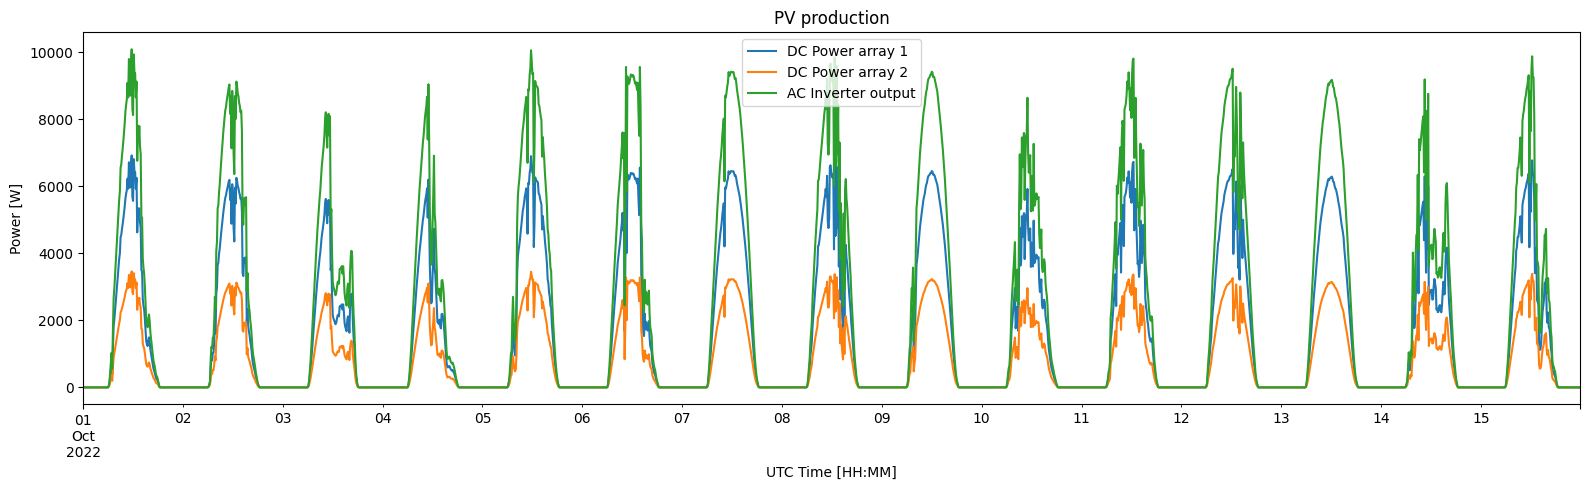

In [11]:
# Plot results
plt.figure(figsize=(16,5))
mc_1.results.dc[0].p_mp.plot(label='DC Power array 1')
mc_1.results.dc[1].p_mp.plot(label='DC Power array 2')
ax = mc_1.results.ac.plot(label='AC Inverter output')
ax.set_ylabel('Power [W]')
ax.set_xlabel('UTC Time [HH:MM]')
ax.set_title('PV production')
plt.legend()
plt.tight_layout()
plt.show()

<h2>Compare with measurements</h2>

In [12]:
# Import PV system data from file
df_PV = pd.read_csv('PV_ENERPOS_01-15-10-2022_bis.txt')
df_PV['datetime'] = pd.to_datetime(df_PV.datetime)
df_PV.set_index('datetime', inplace=True)

df_PV.head()

,POA_NE,POA_SW,Inv1_AC,Inv1_DC_MPPT1,Inv1_DC_MPPT2,Inv2_AC,Inv2_DC_MPPT1,Inv2_DC_MPPT2,Inv3_AC,Inv3_DC_MPPT1,Inv3_DC_MPPT2,Inv4_AC,Inv4_DC_MPPT1,Inv4_DC_MPPT2
datetime,,,,,,,,,,,,,,
2022-10-01 00:00:00+04:00,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
2022-10-01 00:10:00+04:00,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
2022-10-01 00:20:00+04:00,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
2022-10-01 00:30:00+04:00,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
2022-10-01 00:40:00+04:00,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0


In [ ]:
# Select period for plots
start_date = '2022-10-12 00:00:00'
end_date = '2022-10-15 00:00:00'

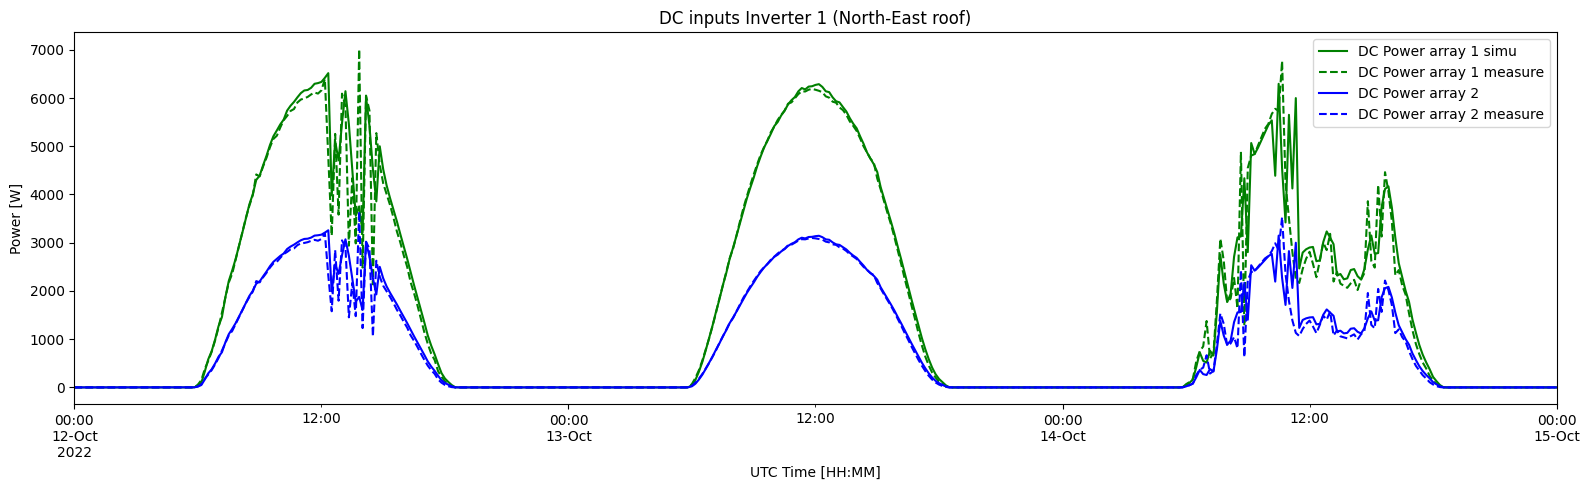

In [32]:
# Plot DC power inverter 1
mask_meas_1 = mc_1.results.dc[0].p_mp.loc[(df_PV.index >= start_date) & (df_PV.index <= end_date)]
mask_meas_2 = mc_1.results.dc[1].p_mp.loc[(df_PV.index >= start_date) & (df_PV.index <= end_date)]
mask_sim = df_PV[(df_PV.index >= start_date) & (df_PV.index <= end_date)]

# Plot
plt.figure(figsize=(16,5))
mask_meas_1.plot(label='DC Power array 1 simu',color='green')
mask_sim['Inv1_DC_MPPT1'].plot(label='DC Power array 1 measure', color='green',linestyle='dashed')
mask_meas_2.plot(label='DC Power array 2', color='blue')
ax = mask_sim['Inv1_DC_MPPT2'].plot(label='DC Power array 2 measure', color='blue',linestyle='dashed')
ax.set_ylabel('Power [W]')
ax.set_xlabel('UTC Time [HH:MM]')
ax.set_title('DC inputs Inverter 1 (North-East roof)')
plt.legend()
plt.tight_layout()
plt.show()

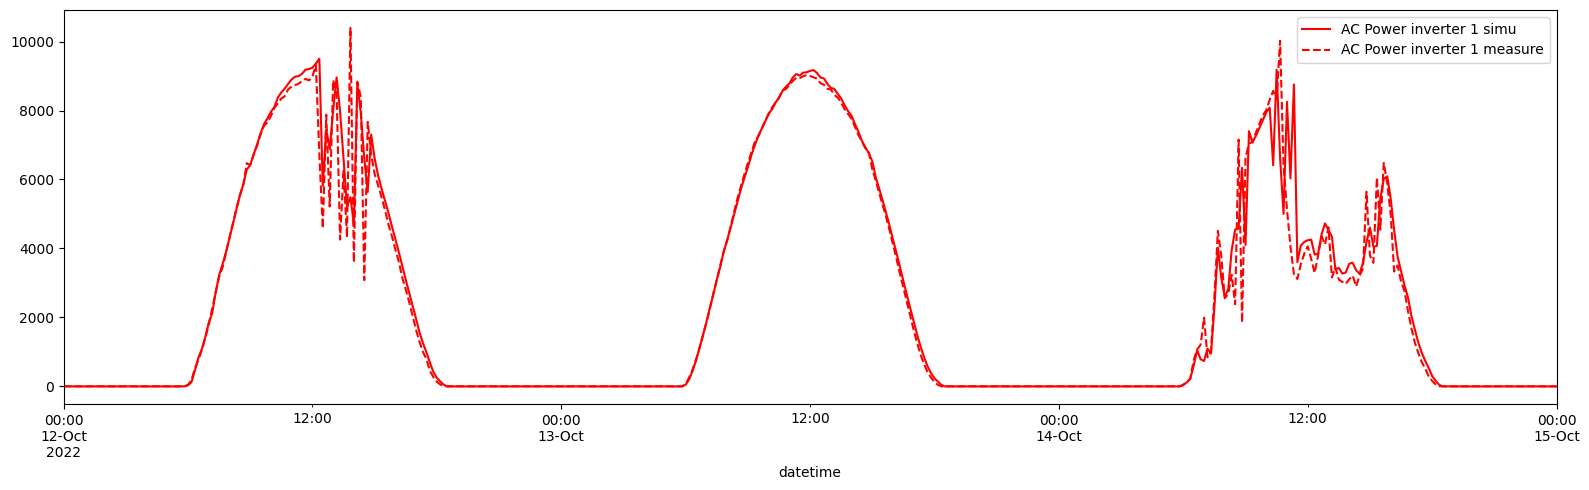

In [34]:
# Plot AC power inverter 1
mask_meas = mc_1.results.ac.loc[(df_PV.index >= start_date) & (df_PV.index <= end_date)]
mask_sim = df_PV[(df_PV.index >= start_date) & (df_PV.index <= end_date)]

# Plot
plt.figure(figsize=(16,5))
mask_meas.plot(label='AC Power inverter 1 simu',color='red')
mask_sim['Inv1_AC'].plot(label='AC Power inverter 1 measure', color='red',linestyle='dashed')
ax.set_ylabel('Power [W]')
ax.set_xlabel('UTC Time [HH:MM]')
ax.set_title('AC output Inverter 1 (North-East roof)')
plt.legend()
plt.tight_layout()
plt.show()